In [1]:
from coffea.nanoevents import NanoEventsFactory
import awkward as ak
import numpy as np
import hist
import pandas as pd
import uproot
import json
import glob
import matplotlib.pyplot as plt

In [2]:
def blocks(lines):
    lines = iter(lines)
    tag, block = "", []
    try:
        while True:
            line = next(lines)
            begintag = "# BEGIN "
            if line.startswith(begintag):
                tag = line[len(begintag):]
                block = []
            elif line.startswith("# END "):
                yield tag, block
            elif len(line):
                block.append(line)
    except StopIteration:
        pass


def tohist(block):
    assert block[0] == '# xlow   xhigh   val   errminus  errplus'
    data = np.fromstring(" ".join(block[1:]), sep=" ").reshape(-1, 5)
    assert np.all(data[1:, 0] == data[:-1, 1])
    edges = np.concatenate([data[:, 0], data[-1:, 1]])
    val, lo, hi = data[:, 2:].T
    h = hist.Hist.new.Var(edges).Weight()
    h.view().value = val
    h.view().variance = (hi - lo)**2 / 4
    return h


def load_yoda(lines):
    hists = {}
    data = {}
    for tag, block in blocks(lines.split("\n")):
        if tag.startswith("HISTO1D"):
            hists[tag[8:]] = tohist(block)
        elif tag.startswith("DATA"):
            for l in block:
                k, v = l.split("=")
                data[k] = v
    return data, hists

In [3]:
import requests

eejmeta, eej = load_yoda(requests.get("https://www.ippp.dur.ac.uk/~jlindert/vjets/eej.dat").text)
vvjmeta, vvj = load_yoda(requests.get("https://www.ippp.dur.ac.uk/~jlindert/vjets/vvj.dat").text)
evjmeta, evj = load_yoda(requests.get("https://www.ippp.dur.ac.uk/~jlindert/vjets/evj.dat").text)
lindert = dict(**eej, **vvj, **evj)

In [4]:
def make_lindert_pred(process, order):
    """Eqn. 76 of https://arxiv.org/pdf/1705.04664.pdf
    
    process: eej, evj, vvj; order: NLO, NNLO
    """
    sigma_lo = lindert[f"{process}_pTV_LO"].values()
    kqcd = lindert[f"{process}_pTV_K_{order}"].values()
    deltas = np.empty((3 + 106, len(kqcd)))
    kewk = lindert[f"{process}_pTV_kappa_EW"].values()
    deltas_ew = np.empty((3, len(kqcd)))
    delta_mix = lindert[f"{process}_pTV_dK_{order}_mix"].values()[None, :]

    for i in range(3):
        deltas[i, :] = lindert[f"{process}_pTV_d{i + 1}K_{order}"].values()

    for i in range(106):
        deltas[i + 3, :] = lindert[f"{process}_pTV_dK_PDF_{i + 1}"].values()

    for i in range(3):
        deltas_ew[i, :] = lindert[f"{process}_pTV_d{i + 1}kappa_EW"].values()

    def pred(epsilon, ew=True):
        """epsilon: (*, 3 + 106 + 3 + 1) (qcd scale, pdf, ewk variation, cross-term)"""
        Kth = (kqcd + epsilon[..., :109] @ deltas)
        if ew:
            Kth *= (1 + kewk + epsilon[..., 109:112] @ deltas_ew)
            Kth += epsilon[..., 112:113] @ delta_mix
        return Kth * sigma_lo
    
    return pred

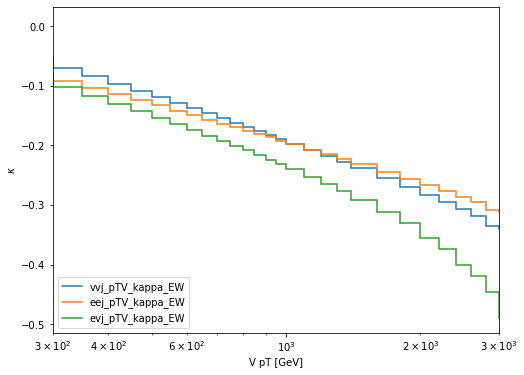

In [5]:
from scipy.interpolate import interp1d

def hinterp(h):
    ax = h.axes[0]
    return interp1d(ax.centers, h.view().value, bounds_error=False)

fig, ax = plt.subplots(figsize=(8, 6))

lindert["vvj_pTV_kappa_EW"].plot(ax=ax, label="vvj_pTV_kappa_EW", yerr=False)
lindert["eej_pTV_kappa_EW"].plot(ax=ax, label="eej_pTV_kappa_EW", yerr=False)
lindert["evj_pTV_kappa_EW"].plot(ax=ax, label="evj_pTV_kappa_EW", yerr=False)


ax.set_xscale("log")
ax.set_xlabel("V pT [GeV]")
ax.set_xlim(300, 3000)
ax.set_ylabel("$\kappa$")
ax.legend()
plt.savefig("V_kappaEW.pdf")

In [12]:
# https://github.com/DAZSLE/boostedzprime/blob/main/data/pfnanoindex.json
with open("../ULpfnano.json") as fin:
    fileset_in = json.load(fin)

xs = {
    # EOY 17/18 samples
    "WJetsToQQ_HT400to600_qc19_3j_TuneCP5_13TeV-madgraphMLM-pythia8": 314.90,
    "WJetsToQQ_HT600to800_qc19_3j_TuneCP5_13TeV-madgraphMLM-pythia8": 68.64,
    "WJetsToQQ_HT-800toInf_qc19_3j_TuneCP5_13TeV-madgraphMLM-pythia8": 34.70,
    "ZJetsToQQ_HT400to600_qc19_4j_TuneCP5_13TeV-madgraphMLM-pythia8": 144.70,
    "ZJetsToQQ_HT600to800_qc19_4j_TuneCP5_13TeV-madgraphMLM-pythia8": 34.06,
    "ZJetsToQQ_HT-800toInf_qc19_4j_TuneCP5_13TeV-madgraphMLM-pythia8": 18.57,
    # UL samples
    "WJetsToQQ_HT-400to600_TuneCP5_13TeV-madgraphMLM-pythia8": 278.0, # 2.780e+02 +- 7.908e-01 pb
    "WJetsToQQ_HT-600to800_TuneCP5_13TeV-madgraphMLM-pythia8": 59.43, # 5.943e+01 +- 1.692e-01 pb
    "WJetsToQQ_HT-800toInf_TuneCP5_13TeV-madgraphMLM-pythia8": 28.72, # 2.872e+01 +- 8.180e-02 pb
    "ZJetsToQQ_HT-400to600_TuneCP5_13TeV-madgraphMLM-pythia8": 114.1, # 1.141e+02 +- 3.437e-01 pb
    "ZJetsToQQ_HT-600to800_TuneCP5_13TeV-madgraphMLM-pythia8": 25.44, # 2.544e+01 +- 7.702e-02 pb
    "ZJetsToQQ_HT-800toInf_TuneCP5_13TeV-madgraphMLM-pythia8": 12.87, # 1.287e+01 +- 3.908e-02 pb
    # UL NLO
    'DYJetsToLL_Pt-100To250_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8':   93.82, # 9.382e+01 +- 6.195e-01 pb
    'DYJetsToLL_Pt-250To400_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8':   3.638, # 3.638e+00 +- 2.237e-02 pb
    'DYJetsToLL_Pt-400To650_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8':  0.4971, # 4.971e-01 +- 2.869e-03 pb
    'DYJetsToLL_Pt-650ToInf_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8': 0.04698, # 4.698e-02 +- 2.515e-04 pb
    "WJetsToLNu_Pt-100To250_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8": 756.9, # 7.569e+02 +- 4.895e+00 pb 
    "WJetsToLNu_Pt-250To400_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8": 27.71, # 2.771e+01 +- 1.628e-01 pb 
    "WJetsToLNu_Pt-400To600_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8": 3.544, # 3.544e+00 +- 1.989e-02 pb 
    "WJetsToLNu_Pt-600ToInf_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8": 0.5399, # 5.399e-01 +- 2.856e-03 pb 
    # EOY monoJet NLO
    "DY1JetsToLL_M-50_LHEZpT_250-400_TuneCP5_13TeV-amcnloFXFX-pythia8": 1.097,
    "DY1JetsToLL_M-50_LHEZpT_400-inf_TuneCP5_13TeV-amcnloFXFX-pythia8": 0.1207,
    "DY2JetsToLL_M-50_LHEZpT_250-400_TuneCP5_13TeV-amcnloFXFX-pythia8": 2.74,
    "DY2JetsToLL_M-50_LHEZpT_400-inf_TuneCP5_13TeV-amcnloFXFX-pythia8": 0.4492,
}

fileset = {
    "WJetsToQQ_HT-400to600_TuneCP5_13TeV-madgraphMLM-pythia8": fileset_in["2018"]["WJetsToQQ"]["WJetsToQQ_HT-400to600"],
    "WJetsToQQ_HT-600to800_TuneCP5_13TeV-madgraphMLM-pythia8": fileset_in["2018"]["WJetsToQQ"]["WJetsToQQ_HT-600to800"],
    "WJetsToQQ_HT-800toInf_TuneCP5_13TeV-madgraphMLM-pythia8": fileset_in["2018"]["WJetsToQQ"]["WJetsToQQ_HT-800toInf"],
    "ZJetsToQQ_HT-400to600_TuneCP5_13TeV-madgraphMLM-pythia8": fileset_in["2018"]["ZJetsToQQ"]["ZJetsToQQ_HT-400to600"],
    "ZJetsToQQ_HT-600to800_TuneCP5_13TeV-madgraphMLM-pythia8": fileset_in["2018"]["ZJetsToQQ"]["ZJetsToQQ_HT-600to800"],
    "ZJetsToQQ_HT-800toInf_TuneCP5_13TeV-madgraphMLM-pythia8": fileset_in["2018"]["ZJetsToQQ"]["ZJetsToQQ_HT-800toInf"],
}
fileset = {
    ds: ["root://cmseos.fnal.gov/" + fn for fn in fl]
    for ds, fl in fileset.items()
}

In [ ]:
fileset = {}
for fl in glob.glob("dsUL/*"):
    with open(fl) as fin:
        fileset[fl[5:]] = ["root://cmsxrootd.fnal.gov/" + l.strip() for l in fin]

In [41]:
import warnings
warnings.filterwarnings("ignore", "Found duplicate branch")

ds = "DYJetsToLL_Pt-400To650_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8"
fn = fileset[ds][0]
events = NanoEventsFactory.from_root(fn, metadata={"dataset": ds}, entry_stop=100000).events()

In [56]:
events.LHEPdfWeight.__doc__

'LHE pdf variation weights (w_var / w_nominal) for LHA IDs 325300 - 325402'

https://lhapdfsets.web.cern.ch/current/NNPDF31_nnlo_as_0118_mc_hessian_pdfas/NNPDF31_nnlo_as_0118_mc_hessian_pdfas.info

https://pdg.lbl.gov/2020/mobile/reviews/pdf/rpp2020-rev-qcd-m.pdf

https://cms-pdmv.cern.ch/mcm/public/restapi/requests/get_fragment/SMP-RunIISummer20UL16wmLHEGENAPV-00050

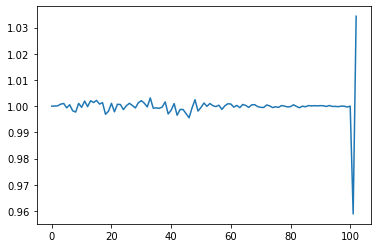

In [54]:
plt.plot(ak.mean(events.LHEPdfWeight, axis=0))

In [57]:
m = ak.mean(events.LHEPdfWeight, axis=0)

In [64]:
np.sqrt(np.sum((m[:100]-1)**2))

0.012275890883551558

In [67]:
(m[101:] - 1)/2

<Array [-0.0206, 0.0172] type='2 * ?float64'>

In [9]:
from coffea import processor

class VPtProc(processor.ProcessorABC):
    edges = np.array([  30.,   40.,   50.,   60.,   70.,   80.,   90.,  100.,  110.,
        120.,  130.,  140.,  150.,  200.,  250.,  300.,  350.,  400.,
        450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
        900.,  950., 1000., 1100., 1200., 1300., 1400., 1600., 1800.,
       2000., 2200., 2400., 2600., 2800., 3000., 6500.])

    def process(self, events):
        boson = ak.firsts(events.GenPart[
            ((events.GenPart.pdgId == 23)|(abs(events.GenPart.pdgId) == 24))
            & events.GenPart.hasFlags(["fromHardProcess", "isLastCopy"])
        ])
        vpt = ak.fill_none(boson.pt, 0.)
        offshell = events.GenPart[
            events.GenPart.hasFlags(["fromHardProcess", "isLastCopy"])
            & ak.is_none(boson)
            & (abs(events.GenPart.pdgId) >= 11) & (abs(events.GenPart.pdgId) <= 16)
        ].sum()
        scalevar = (
            hist.Hist.new
            .IntCat(range(8))
            .Var(self.edges).Weight()
        )
        for i in range(8):
            scalevar.fill(i, vpt + offshell.pt, weight=events.genWeight * events.LHEScaleWeight[:, i])

        return {
            events.metadata["dataset"]: {
                "Vpt_resonant": (
                    hist.Hist.new
                    .Var(self.edges).Weight()
                    .fill(vpt, weight=events.genWeight)
                ),
                "Vpt_nano": (
                    hist.Hist.new
                    .Var(self.edges).Weight()
                    .fill(events.LHE.Vpt, weight=events.genWeight)
                ),
                "Vpt": (
                    hist.Hist.new
                    .Var(self.edges).Weight()
                    .fill(vpt + offshell.pt, weight=events.genWeight)
                ),
                "Vptscale": scalevar,
                "Vmass": (
                    hist.Hist.new
                    .StrCat(["V", "offshell"])
                    .Reg(105, 30, 240, name="mass")
                    .Weight()
                    .fill("V", ak.fill_none(boson.mass, 0.), weight=events.genWeight)
                    .fill("offshell", offshell.mass, weight=events.genWeight)
                ),
                "sumw": ak.sum(events.genWeight),
            }
        }

    def postprocess(self, x):
        return x
    
vptproc = VPtProc()

In [71]:
from distributed import Client
from lpcjobqueue import LPCCondorCluster


cluster = LPCCondorCluster()
cluster.adapt(minimum=1, maximum=200)
client = Client(cluster)

In [72]:
from dask.distributed import performance_report
import datetime
import json
import coffea.util


now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
with performance_report(filename=f"daskreport_{now}.html"):
    res, stats = processor.run_uproot_job(
        fileset, "Events", vptproc, processor.dask_executor,
        {
            "client": client,
            "schema": processor.NanoAODSchema,
            "savemetrics": True,
            "skipbadfiles": True,
        },
    )
    

def serialize_sets(obj):
    if isinstance(obj, set):
        return list(obj)

    return obj

with open(f"stats_{now}.json", "w") as fout:
    json.dump(stats, fout, indent=4, default=serialize_sets)
    

coffea.util.save(res, f"run_{now}.coffea")

In [73]:
client.close()
cluster.close()

In [10]:
import coffea.util
res = processor.accumulate([
    # EOY2017 samples
    coffea.util.load("run_20210423_132139.coffea"),
    # UL2018 samples
    coffea.util.load("run_20220216_113827.coffea"),
    # UL leptons
    coffea.util.load("run_20220217_190739.coffea"),
])

In [13]:
scaled = {}
for ds, plots in res.items():
    if ds not in xs:
        continue
    xsw = xs[ds] / plots["sumw"]
    lum = plots["Vpt_nano"].sum(flow=True)
    sds = {
        "samples": {(ds, xs[ds], lum.value**2 / lum.variance / xs[ds] / 1000)}
    }
    for name, h in plots.items():
        if isinstance(h, hist.Hist):
            h = h.copy()
            h.view().value *= xsw
            h.view().variance *= xsw**2
            if "Vpt" in name:
                h.view().value /= h.axes[-1].widths
                h.view().variance /= h.axes[-1].widths**2
            sds[name] = h
    scaled[ds] = sds

In [14]:
print("\n".join(scaled))

WJetsToQQ_HT-800toInf_qc19_3j_TuneCP5_13TeV-madgraphMLM-pythia8
DY1JetsToLL_M-50_LHEZpT_250-400_TuneCP5_13TeV-amcnloFXFX-pythia8
DY2JetsToLL_M-50_LHEZpT_400-inf_TuneCP5_13TeV-amcnloFXFX-pythia8
DY2JetsToLL_M-50_LHEZpT_250-400_TuneCP5_13TeV-amcnloFXFX-pythia8
DY1JetsToLL_M-50_LHEZpT_400-inf_TuneCP5_13TeV-amcnloFXFX-pythia8
ZJetsToQQ_HT600to800_qc19_4j_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToQQ_HT-800toInf_qc19_4j_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToQQ_HT400to600_qc19_4j_TuneCP5_13TeV-madgraphMLM-pythia8
WJetsToQQ_HT600to800_qc19_3j_TuneCP5_13TeV-madgraphMLM-pythia8
WJetsToQQ_HT400to600_qc19_3j_TuneCP5_13TeV-madgraphMLM-pythia8
WJetsToQQ_HT-800toInf_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToQQ_HT-400to600_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToQQ_HT-600to800_TuneCP5_13TeV-madgraphMLM-pythia8
WJetsToQQ_HT-600to800_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToQQ_HT-800toInf_TuneCP5_13TeV-madgraphMLM-pythia8
WJetsToQQ_HT-400to600_TuneCP5_13TeV-madgraphMLM-pythia8
DYJetsToLL_Pt-100To250_M

In [15]:
cms_zqqj_mlm = processor.accumulate([v for k, v in scaled.items() if "ZJetsToQQ" in k and "qc19" in k])
cms_wqqj_mlm = processor.accumulate([v for k, v in scaled.items() if "WJetsToQQ" in k and "qc19" in k])
cms_zqqj_mlmUL = processor.accumulate([v for k, v in scaled.items() if "ZJetsToQQ" in k and "qc19" not in k])
cms_wqqj_mlmUL = processor.accumulate([v for k, v in scaled.items() if "WJetsToQQ" in k and "qc19" not in k])
cms_zll_nloUL = processor.accumulate([v for k, v in scaled.items() if "DYJetsToLL" in k])
cms_wlv_nloUL = processor.accumulate([v for k, v in scaled.items() if "WJetsToLNu" in k])

cms_llj = processor.accumulate([v for k, v in scaled.items() if "DY1JetsToLL" in k or "DY2JetsToLL" in k])


In [16]:
df = pd.DataFrame(
#     sorted(("CMS Z(qq)+4j MLM",) + tup for tup in cms_zqqj_mlm["samples"])
#     + sorted(("CMS W(qq)+2j MLM",) + tup  for tup in cms_wqqj_mlm["samples"])
    sorted(("CMS Z(qq)+4j MLM UL",) + tup for tup in cms_zqqj_mlmUL["samples"])
    + sorted(("CMS W(qq)+2j MLM UL",) + tup  for tup in cms_wqqj_mlmUL["samples"])
    + sorted(("CMS Z(ll)+2j NLO UL",) + tup  for tup in cms_zll_nloUL["samples"])
    + sorted(("CMS W(lv)+2j NLO UL",) + tup  for tup in cms_wlv_nloUL["samples"]),
    columns=["Sample", "PD component", "$\sigma$ [pb]", "Effective lumi [1/fb]"]
)
# print(df.set_index(["Sample", "PD component"]).to_latex())
df.set_index(["Sample", "PD component"])

$\sigma$ [pb]  \
Sample              PD component                                                        
CMS Z(qq)+4j MLM UL ZJetsToQQ_HT-400to600_TuneCP5_13TeV-madgraphMLM...      114.10000   
                    ZJetsToQQ_HT-600to800_TuneCP5_13TeV-madgraphMLM...       25.44000   
                    ZJetsToQQ_HT-800toInf_TuneCP5_13TeV-madgraphMLM...       12.87000   
CMS W(qq)+2j MLM UL WJetsToQQ_HT-400to600_TuneCP5_13TeV-madgraphMLM...      278.00000   
                    WJetsToQQ_HT-600to800_TuneCP5_13TeV-madgraphMLM...       59.43000   
                    WJetsToQQ_HT-800toInf_TuneCP5_13TeV-madgraphMLM...       28.72000   
CMS Z(ll)+2j NLO UL DYJetsToLL_Pt-100To250_MatchEWPDG20_TuneCP5_13T...       93.82000   
                    DYJetsToLL_Pt-250To400_MatchEWPDG20_TuneCP5_13T...        3.63800   
                    DYJetsToLL_Pt-400To650_MatchEWPDG20_TuneCP5_13T...        0.49710   
                    DYJetsToLL_Pt-650ToInf_MatchEWPDG20_TuneCP5_13T...        0.04698   
CMS W(lv)+2j NLO UL WJetsToLNu_Pt-100To250_MatchEWPDG20_TuneCP5_13T...      756.90000   
                    WJetsToLNu_Pt-250To400_MatchEWPDG20_TuneCP5_13T...       27.71000   
                    WJetsToLNu_Pt-400To600_MatchEWPDG20_TuneCP5_13T...        3.54400   
                    WJetsToLNu_Pt-600ToInf_MatchEWPDG20_TuneCP5_13T...        0.53990   

                                                                        Effective lumi [1/fb]  
Sample              PD component                                                               
CMS Z(qq)+4j MLM UL ZJetsToQQ_HT-400to600_TuneCP5_13TeV-madgraphMLM...             121.963637  
                    ZJetsToQQ_HT-600to800_TuneCP5_13TeV-madgraphMLM...             478.727673  
                    ZJetsToQQ_HT-800toInf_TuneCP5_13TeV-madgraphMLM...             759.167055  
CMS W(qq)+2j MLM UL WJetsToQQ_HT-400to600_TuneCP5_13TeV-madgraphMLM...              33.580209  
                    WJetsToQQ_HT-600to800_TuneCP5_13TeV-madgraphMLM...             229.399731  
                    WJetsToQQ_HT-800toInf_TuneCP5_13TeV-madgraphMLM...             494.258809  
CMS Z(ll)+2j NLO UL DYJetsToLL_Pt-100To250_MatchEWPDG20_TuneCP5_13T...             115.595811  
                    DYJetsToLL_Pt-250To400_MatchEWPDG20_TuneCP5_13T...             782.342160  
                    DYJetsToLL_Pt-400To650_MatchEWPDG20_TuneCP5_13T...             647.645993  
                    DYJetsToLL_Pt-650ToInf_MatchEWPDG20_TuneCP5_13T...            8237.700837  
CMS W(lv)+2j NLO UL WJetsToLNu_Pt-100To250_MatchEWPDG20_TuneCP5_13T...              91.676496  
                    WJetsToLNu_Pt-250To400_MatchEWPDG20_TuneCP5_13T...             600.221062  
                    WJetsToLNu_Pt-400To600_MatchEWPDG20_TuneCP5_13T...             626.809184  
                    WJetsToLNu_Pt-600ToInf_MatchEWPDG20_TuneCP5_13T...            1420.212900

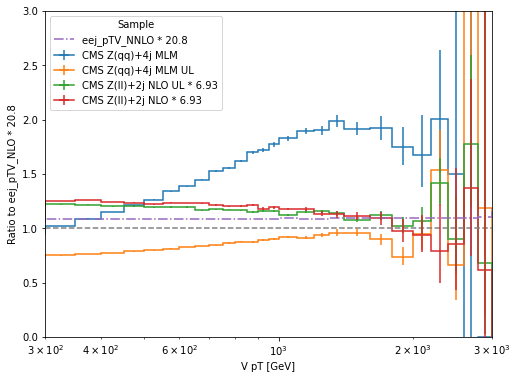

In [17]:
fig, ax = plt.subplots(figsize=(8, 6), facecolor="w")

name = "Vpt"
den = lindert["eej_pTV_NLO"].values() * 20.8
ax.axhline(1, color="grey", linestyle="--")

def scale(h, s):
    h = h.copy()
    h.view().value *= s
    h.view().variance *= s**2
    return h


scale(cms_zqqj_mlm[name], 1 / den).plot1d(label="CMS Z(qq)+4j MLM")
scale(cms_zqqj_mlmUL[name], 1 / den).plot1d(label="CMS Z(qq)+4j MLM UL")
scale(cms_zll_nloUL[name], 6.93 / den).plot1d(label="CMS Z(ll)+2j NLO UL * 6.93")
scale(cms_llj[name], 6.93 / den).plot1d(label="CMS Z(ll)+2j NLO * 6.93")

scale(lindert["eej_pTV_NNLO"], 20.8 / den).plot1d(yerr=False, linestyle="-.", label="eej_pTV_NNLO * 20.8")

ax.set_xscale("log")
ax.set_xlim(300, 3000)
ax.set_ylim(0., 3.)
ax.set_ylabel("Ratio to eej_pTV_NLO * 20.8")
ax.set_xlabel("V pT [GeV]")
ax.legend(title="Sample", loc="upper left")
fig.savefig("ULZqqPt_vs_lindertNLO.pdf")

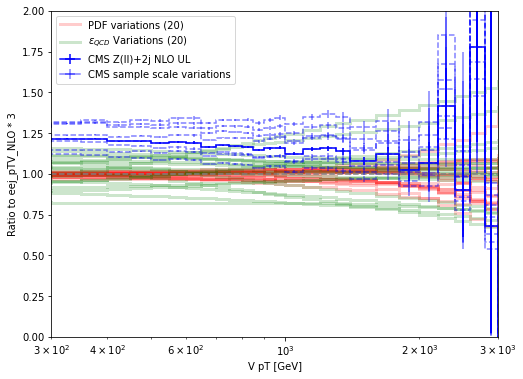

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

order = "NLO"
eej_qcd = make_lindert_pred("eej", order)
den = eej_qcd(np.zeros(113), ew=False) * 3
ax.axhline(1, color="grey", linestyle="--")

def scale(h, s):
    h = h.copy()
    h.view().value *= s
    h.view().variance *= s**2
    return h

systs = np.random.normal(size=(20, 113))
systs[:, :3] = 0.
reps = eej_qcd(systs, ew=False) * 3 / den
for i, rep in enumerate(reps):
    ax.stairs(rep, vptproc.edges, color="r", alpha=0.2, linewidth=3, 
              label="PDF variations (20)" if i==0 else None)

systs = np.random.normal(size=(20, 113))
systs[:, 3:] = 0.
reps = eej_qcd(systs, ew=False) * 3 / den
for i, rep in enumerate(reps):
    ax.stairs(rep, vptproc.edges, color="g", alpha=0.2, linewidth=3, 
              label="$\epsilon_{QCD}$ Variations (20)" if i==0 else None)
    
scale(cms_zll_nloUL["Vpt"], 1 / den).plot1d(label="CMS Z(ll)+2j NLO UL", color="b")
scalevar = scale(cms_zll_nloUL["Vptscale"], 1 / den)
for i in range(8):
    scalevar[i, :].plot1d(ax=ax, color="b", alpha=0.5, linestyle="--",
                            label="CMS sample scale variations" if i==0 else None
                           )

# ax.stairs(eej_qcd(fit.x) * 3 / den, vptproc.edges, color="g", linewidth=3, label="Fit!")

ax.set_xscale("log")
ax.set_xlim(300, 3000)
ax.set_ylim(0., 2.)
ax.set_ylabel(f"Ratio to eej_pTV_{order} * 3")
ax.set_xlabel("V pT [GeV]")
ax.legend(loc="upper left")
fig.savefig(f"ULZPtNLO_vs_lindert{order}.pdf")

In [26]:
def polyfit(h, deg, barycenter=0.5):
    x = h.axes[-1].edges[:-1] + np.diff(h.axes[-1].edges) * barycenter
    y = h.values()
    yerr = np.sqrt(h.variances())
    mask = (y > 0) & (yerr > 0)
    x, y, yerr = x[mask], y[mask], yerr[mask]
    return np.polyfit(np.log(x), y, deg, w=1/yerr)


def horner(v, xstr):
    if len(v) > 1:
        return f"({horner(v[:-1], xstr)})*{xstr} + {v[-1]}"
    return f"{v[0]}"

eval(horner([1, 2, 3], "log(x)"), {"log": np.log, "x": 3}) - np.polyval([1,2,3], np.log(3))

0.0

/tmp/ipykernel_32281/3785546345.py:22: RuntimeWarning: invalid value encountered in true_divide
  val = num.view().value / den.view().value
/tmp/ipykernel_32281/3785546345.py:24: RuntimeWarning: divide by zero encountered in true_divide
  num.view().variance / den.view().value**2
/tmp/ipykernel_32281/3785546345.py:25: RuntimeWarning: invalid value encountered in true_divide
  + den.view().variance * num.view().value**2 / den.view().value**4
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/tmp/ipykernel_32281/3785546345.py:22: RuntimeWarning: divide by zero encountered in true_divide
  val = num.view().value / den.view().value
/tmp/ipykernel_32281/3785546345.py:24: Runti

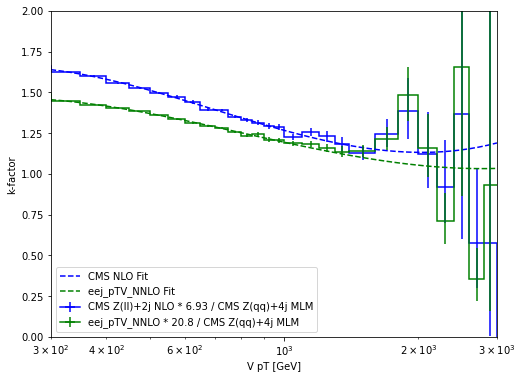

In [28]:
from correctionlib.schemav2 import CorrectionSet, Correction, Variable
from correctionlib.convert import from_histogram
import correctionlib

def evaluator(corr):
    cset = CorrectionSet(schema_version=2, corrections=[corr])
    return np.vectorize(
        correctionlib.CorrectionSet(cset)[corr.name].evaluate,
    )


vptvar = Variable(
    name="vpt",
    type="real",
    description="Generated boson pT (status 62: fromHardProcess, isLastCopy) or sum(leptons).pt if virtual"
)

fig, ax = plt.subplots(figsize=(8, 6))


def ratio(num, den):
    val = num.view().value / den.view().value
    var = (
        num.view().variance / den.view().value**2
        + den.view().variance * num.view().value**2 / den.view().value**4
    )
    num = num.copy()
    num.view().value = val
    num.view().variance = var
    return num


x = np.geomspace(300, 3000)


tofxfx = ratio(
    scale(cms_zll_nloUL["Vpt"], 6.93),
    cms_zqqj_mlmUL["Vpt"],
)
tofxfx_fit = polyfit(tofxfx[hist.loc(300):], 3)
z_tofxfx_corr = Correction(
    name="ULZ_MLMtoFXFX",
    version=1,
    description="k_CMS(ptv), or CMS Z(ll)+2j NLO * 6.93 / CMS Z(qq)+4j MLM for UltraLegacy sample",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "vpt",
        "edges": [299, 300, 3000, 3001],
        "content": [
            np.polyval(tofxfx_fit, np.log(300)),
            {
                "nodetype": "formula",
                "variables": ["vpt"],
                "parser": "TFormula",
                "expression": horner(tofxfx_fit, "log(x)"),
            },
            np.polyval(tofxfx_fit, np.log(3000)),
        ],
        "flow": "clamp",
    },
)
tofxfx.plot1d(ax=ax, label="CMS Z(ll)+2j NLO * 6.93 / CMS Z(qq)+4j MLM", color="b")
ax.plot(x, evaluator(z_tofxfx_corr)(x), label="CMS NLO Fit", color="b", linestyle="--")


tolindert = ratio(
    scale(lindert["eej_pTV_NNLO"], 20.8),
    cms_zqqj_mlmUL["Vpt"],
)
tolindert_fit = polyfit(tolindert[hist.loc(300):], 3)
z_tolindert_corr = Correction(
    name="ULZ_MLMtoNNLOQCD",
    version=1,
    description="eej_pTV_NNLO * 20.8 / CMS Z(qq)+4j MLM for UltraLegacy sample",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "vpt",
        "edges": [299, 300, 3000, 3001],
        "content": [
            np.polyval(tolindert_fit, np.log(300)),
            {
                "nodetype": "formula",
                "variables": ["vpt"],
                "parser": "TFormula",
                "expression": horner(tolindert_fit, "log(x)"),
            },
            np.polyval(tolindert_fit, np.log(3000)),
        ],
        "flow": "clamp",
    },
)
tolindert.plot1d(ax=ax, label="eej_pTV_NNLO * 20.8 / CMS Z(qq)+4j MLM", color="g")
ax.plot(x, evaluator(z_tolindert_corr)(x), label="eej_pTV_NNLO Fit", color="g", linestyle="--")

ax.set_xscale("log")
ax.set_ylim(0, 2)
ax.set_xlim(300, 3000)
ax.set_ylabel("k-factor")
ax.set_xlabel("V pT [GeV]")
ax.legend()
fig.savefig("Z_kCMS_UL.pdf")

In [29]:
den = lindert["eej_pTV_LO"].values() * lindert["eej_pTV_K_NLO"].values()

def binning(idx, shift):
    epsilon = np.zeros(113)
    epsilon[idx] = shift
    return {
        "nodetype": "binning",
        "input": "vpt",
        "edges": list(vptproc.edges),
        "content": list(eej_qcd(epsilon) / den),
        "flow": "clamp",
    }


z_fixedorder_corr = Correction(
    name="Z_FixedOrderComponent",
    version=1,
    description="Z boson K_TH(vpt, ...) / K_NLO(vpt, ...)",
    inputs=[Variable(name="systematic", type="string"), vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "category",
        "input": "systematic",
        "content": [
            {"key": "nominal", "value": binning(0, 0)},
            {"key": "d1K_NLO_up", "value": binning(0, +1)},
            {"key": "d2K_NLO_up", "value": binning(1, +1)},
            {"key": "d3K_NLO_up", "value": binning(2, +1)},
            {"key": "d1K_NLO_down", "value": binning(0, -1)},
            {"key": "d2K_NLO_down", "value": binning(1, -1)},
            {"key": "d3K_NLO_down", "value": binning(2, -1)},
            {"key": "d1kappa_EW_up", "value": binning(109, +1)},
            {"key": "Z_d2kappa_EW_up", "value": binning(110, +1)},
            {"key": "Z_d3kappa_EW_up", "value": binning(111, +1)},
            {"key": "d1kappa_EW_down", "value": binning(109, -1)},
            {"key": "Z_d2kappa_EW_down", "value": binning(110, -1)},
            {"key": "Z_d3kappa_EW_down", "value": binning(111, -1)},
        ]
    },
)

/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale


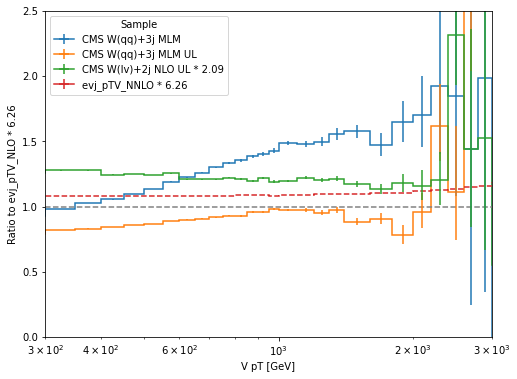

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

name = "Vpt"
den = lindert["evj_pTV_NLO"].values() * 6.26
ax.axhline(1, color="grey", linestyle="--")

scale(cms_wqqj_mlm[name], 1 / den).plot1d(label="CMS W(qq)+3j MLM")
scale(cms_wqqj_mlmUL[name], 1 / den).plot1d(label="CMS W(qq)+3j MLM UL")
scale(cms_wlv_nloUL[name], 2.09 / den).plot1d(label="CMS W(lv)+2j NLO UL * 2.09")

scale(lindert["evj_pTV_NNLO"], 6.26 / den).plot1d(linestyle="--", label="evj_pTV_NNLO * 6.26")

ax.set_xscale("log")
ax.set_xlim(300, 3000)
ax.set_ylim(0., 2.5)
ax.set_ylabel("Ratio to evj_pTV_NLO * 6.26")
ax.set_xlabel("V pT [GeV]")
ax.legend(title="Sample", loc="upper left")
fig.savefig("ULWqqPt_vs_lindertNLO.pdf")

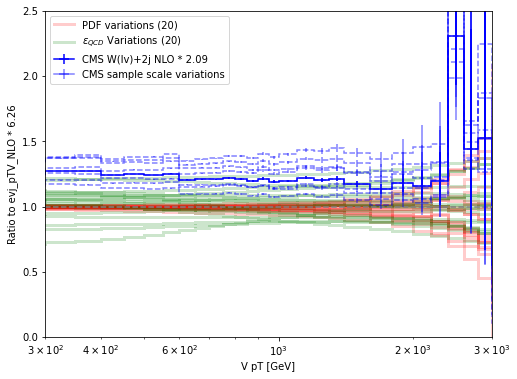

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))

order = "NLO"
evj_qcd = make_lindert_pred("evj", order)
den = evj_qcd(np.zeros(113), ew=False) * 6.26
ax.axhline(1, color="grey", linestyle="--")


systs = np.random.normal(size=(20, 113))
systs[:, :3] = 0.
reps = evj_qcd(systs, ew=False) * 6.26 / den
for i, rep in enumerate(reps):
    ax.stairs(rep, vptproc.edges, color="r", alpha=0.2, linewidth=3, 
              label="PDF variations (20)" if i==0 else None)

systs = np.random.normal(size=(20, 113))
systs[:, 3:] = 0.
reps = evj_qcd(systs, ew=False) * 6.26 / den
for i, rep in enumerate(reps):
    ax.stairs(rep, vptproc.edges, color="g", alpha=0.2, linewidth=3, 
              label="$\epsilon_{QCD}$ Variations (20)" if i==0 else None)

scale(cms_wlv_nloUL[name], 2.09 / den).plot1d(label="CMS W(lv)+2j NLO * 2.09", color="b")
scalevar = scale(cms_wlv_nloUL["Vptscale"], 2.09 / den)
for i in range(8):
    scalevar[i, :].plot1d(ax=ax, color="b", alpha=0.5, linestyle="--",
                            label="CMS sample scale variations" if i==0 else None
                           )

ax.set_xscale("log")
ax.set_xlim(300, 3000)
ax.set_ylim(0., 2.5)
ax.set_ylabel(f"Ratio to evj_pTV_{order} * 6.26")
ax.set_xlabel("V pT [GeV]")
ax.legend(loc="upper left")
fig.savefig(f"ULWPtFXFX_vs_lindert{order}.pdf")

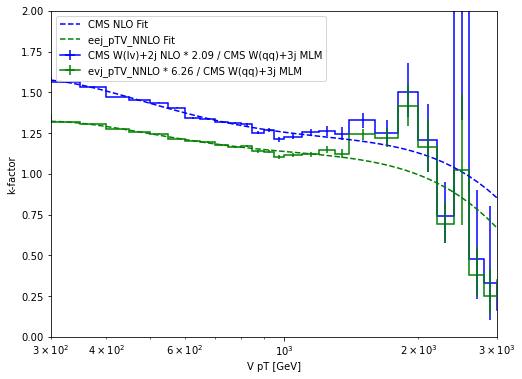

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))

# evj["evj_pTV_K_NLO"].plot(ax=ax, yerr=False, label="evj_pTV_K_NLO")
# evj["evj_pTV_K_NNLO"].plot(ax=ax, yerr=False, label="evj_pTV_K_NNLO")

tofxfx = ratio(
    scale(cms_wlv_nloUL["Vpt"], 2.09),
    cms_wqqj_mlmUL["Vpt"],
)
tofxfx_fit = polyfit(tofxfx[hist.loc(300):], 4)
w_tofxfx_corr = Correction(
    name="ULW_MLMtoFXFX",
    version=1,
    description="k_CMS(vpt), or CMS W(lv)+2j NLO * 2.09 / CMS W(qq)+3j MLM",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "vpt",
        "edges": [299, 300, 3000, 3001],
        "content": [
            np.polyval(tofxfx_fit, np.log(300)),
            {
                "nodetype": "formula",
                "variables": ["vpt"],
                "parser": "TFormula",
                "expression": horner(tofxfx_fit, "log(x)"),
            },
            np.polyval(tofxfx_fit, np.log(3000)),
        ],
        "flow": "clamp",
    },
)
tofxfx.plot1d(ax=ax, label="CMS W(lv)+2j NLO * 2.09 / CMS W(qq)+3j MLM", color="b")
ax.plot(x, evaluator(w_tofxfx_corr)(x), label="CMS NLO Fit", color="b", linestyle="--")


tolindert = ratio(
    scale(evj["evj_pTV_NNLO"], 6.26),
    cms_wqqj_mlmUL["Vpt"],
)
tolindert_fit = polyfit(tolindert[hist.loc(300):], 4)
w_tolindert_corr = Correction(
    name="ULW_MLMtoNNLOQCD",
    version=1,
    description="k_CMS(vpt), or evj_pTV_NNLO * 6.26 / CMS W(qq)+3j MLM",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "vpt",
        "edges": [299, 300, 3000, 3001],
        "content": [
            np.polyval(tolindert_fit, np.log(300)),
            {
                "nodetype": "formula",
                "variables": ["vpt"],
                "parser": "TFormula",
                "expression": horner(tolindert_fit, "log(x)"),
            },
            np.polyval(tolindert_fit, np.log(3000)),
        ],
        "flow": "clamp",
    },
)
tolindert.plot1d(ax=ax, label="evj_pTV_NNLO * 6.26 / CMS W(qq)+3j MLM", color="g")
ax.plot(x, evaluator(w_tolindert_corr)(x), label="eej_pTV_NNLO Fit", color="g", linestyle="--")

ax.set_xscale("log")
ax.set_ylim(0, 2)
ax.set_xlim(300, 3000)
ax.set_ylabel("k-factor")
ax.set_xlabel("V pT [GeV]")
ax.legend()
fig.savefig("W_kCMS_UL.pdf")

In [36]:
den = lindert["evj_pTV_LO"].values() * lindert["evj_pTV_K_NLO"].values()

def binning(idx, shift):
    epsilon = np.zeros(113)
    epsilon[idx] = shift
    return {
        "nodetype": "binning",
        "input": "vpt",
        "edges": list(vptproc.edges),
        "content": list(evj_qcd(epsilon) / den),
        "flow": "clamp",
    }


w_fixedorder_corr = Correction(
    name="W_FixedOrderComponent",
    version=1,
    description="W boson K_TH(vpt, ...) / K_NLO(vpt, ...)",
    inputs=[Variable(name="systematic", type="string"), vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "category",
        "input": "systematic",
        "content": [
            {"key": "nominal", "value": binning(0, 0)},
            {"key": "d1K_NLO_up", "value": binning(0, +1)},
            {"key": "d2K_NLO_up", "value": binning(1, +1)},
            {"key": "d3K_NLO_up", "value": binning(2, +1)},
            {"key": "d1K_NLO_down", "value": binning(0, -1)},
            {"key": "d2K_NLO_down", "value": binning(1, -1)},
            {"key": "d3K_NLO_down", "value": binning(2, -1)},
            {"key": "d1kappa_EW_up", "value": binning(109, +1)},
            {"key": "W_d2kappa_EW_up", "value": binning(110, +1)},
            {"key": "W_d3kappa_EW_up", "value": binning(111, +1)},
            {"key": "d1kappa_EW_down", "value": binning(109, -1)},
            {"key": "W_d2kappa_EW_down", "value": binning(110, -1)},
            {"key": "W_d3kappa_EW_down", "value": binning(111, -1)},
        ]
    },
)

In [37]:
cset = CorrectionSet(
    schema_version=2,
    corrections=[
        z_tofxfx_corr,
        z_tolindert_corr,
        z_fixedorder_corr,
        w_tofxfx_corr,
        w_tolindert_corr,
        w_fixedorder_corr,
    ]
)

import rich

rich.print(cset)
with open("ULvjets_corrections.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

CorrectionSet (schema v2)                                                                    
No description                                                                               
📂                                                                                           
├── 📈 ULZ_MLMtoFXFX (v1)                                                                    
│   k_CMS(ptv), or CMS Z(ll)+2j NLO * 6.93 / CMS Z(qq)+4j MLM for UltraLegacy sample         
│   Node counts: Binning: 1, Formula: 1                                                      
│   ╭─────────────────────────────────────── ▶ input ───────────────────────────────────────╮
│   │ vpt (real)                                                                            │
│   │ Generated boson pT (status 62: fromHardProcess, isLastCopy) or sum(leptons).pt if     │
│   │ virtual                                                                               │
│   │ Range: [-inf, inf), overflow ok                                                       │
│   ╰───────────────────────────────────────────────────────────────────────────────────────╯
│   ╭─────── ◀ output ────────╮                                                              
│   │ out (real)              │                                                              
│   │ Multiplicative k-factor │                                                              
│   ╰─────────────────────────╯                                                              
├── 📈 ULZ_MLMtoNNLOQCD (v1)                                                                 
│   eej_pTV_NNLO * 20.8 / CMS Z(qq)+4j MLM for UltraLegacy sample                            
│   Node counts: Binning: 1, Formula: 1                                                      
│   ╭─────────────────────────────────────── ▶ input ───────────────────────────────────────╮
│   │ vpt (real)                                                                            │
│   │ Generated boson pT (status 62: fromHardProcess, isLastCopy) or sum(leptons).pt if     │
│   │ virtual                                                                               │
│   │ Range: [-inf, inf), overflow ok                                                       │
│   ╰───────────────────────────────────────────────────────────────────────────────────────╯
│   ╭─────── ◀ output ────────╮                                                              
│   │ out (real)              │                                                              
│   │ Multiplicative k-factor │                                                              
│   ╰─────────────────────────╯                                                              
├── 📈 Z_FixedOrderComponent (v1)                                                            
│   Z boson K_TH(vpt, ...) / K_NLO(vpt, ...)                                                 
│   Node counts: Category: 1, Binning: 13                                                    
│   ╭─────────────────────────────────────── ▶ input ───────────────────────────────────────╮
│   │ systematic (string)                                                                   │
│   │ No description                                                                        │
│   │ Values: Z_d2kappa_EW_down, Z_d2kappa_EW_up, Z_d3kappa_EW_down, Z_d3kappa_EW_up,       │
│   │ d1K_NLO_down, d1K_NLO_up, d1kappa_EW_down, d1kappa_EW_up, d2K_NLO_down, d2K_NLO_up,   │
│   │ d3K_NLO_down, d3K_NLO_up, nominal                                                     │
│   ╰───────────────────────────────────────────────────────────────────────────────────────╯
│   ╭─────────────────────────────────────── ▶ input ───────────────────────────────────────╮
│   │ vpt (real)                                                                            │
│   │ Generated boson pT (status 62: fromHardProcess, isLastCopy) or sum(leptons).pt if     │
│   │ virtual                                           